In this notebook, we will implement our k-means clustering algorithm.

First, we need to import the necessary libraries and do some preprocessing on our dataframe

In [2]:
# Import necessary libraries


%matplotlib inline
import re
from os import path, getenv, environ
from typing import Dict

from datetime import datetime

import folium
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import plotly.express as px
import scipy
import scipy.stats as stats
import seaborn as sns
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

set_config(display="diagram", print_changed_only=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Load the full merged dataframe containing data from 2022, 2023 and 2024

base_class = pd.read_csv("full_data.csv", sep=",")

<ipython-input-3-d8f5c908f884>:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  base_class = pd.read_csv("full_data.csv", sep=",")


In [4]:
base_class.head()

,entite_eco,personne_morale,annee_soins,colloc,adh_fac,type_cont,genre,code_postal,Age22,type_benef,tranche_age22,Foyer22,rg_benef,PRES2201,PRES2202,PRES2203,PRES2204,PRES2205,PRES2206,PRES2207,PRES2208,PRES2209,PRES2210,PRES2211,PRES2212,ra_0122,ra_0222,ra_0322,ra_0422,ra_0522,ra_0622,ra_0722,ra_0822,ra_0922,ra_1022,ra_1122,ra_1222,fra_0122,fra_0222,fra_0322,fra_0422,fra_0522,fra_0622,fra_0722,fra_0822,fra_0922,fra_1022,fra_1122,fra_1222,PRES2301,PRES2302,PRES2303,PRES2304,PRES2305,PRES2306,PRES2307,PRES2308,PRES2309,PRES2310,PRES2311,PRES2312,ra_0123,ra_0223,ra_0323,ra_0423,ra_0523,ra_0623,ra_0723,ra_0823,ra_0923,ra_1023,ra_1123,ra_1223,fra_0123,fra_0223,fra_0323,fra_0423,fra_0523,fra_0623,fra_0723,fra_0823,fra_0923,fra_1023,fra_1123,fra_1223,PRES2401,PRES2402,PRES2403,PRES2404,PRES2405,PRES2406,PRES2407,PRES2408,PRES2409,PRES2410,PRES2411,PRES2412,ra_0124,ra_0224,ra_0324,ra_0424,ra_0524,ra_0624,ra_0724,ra_0824,fra_0224,fra_0324,fra_0424,fra_0524,fra_0624,fra_0724,fra_0824
0,EE7,PM7,2022.0,non,non,0.0,Femme,13540.0,45.0,Salarié,[45.0; 50.0[,Salarié et conjoint et 2 enfants,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.590000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.0,1.68,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EE2703,PM3563,2022.0,non,non,0.0,Enfant,41000.0,10.0,Enfant mineur,[0; 18[,Salarié et conjoint et 2 enfants,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.602857,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.0,0.00,0.0,1.72,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EE1979,PM2,2022.0,0,0,0.0,Enfant,99999.0,3.0,Enfant mineur,[0; 18[,Salarié et conjoint et 3+ enfants,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.068571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.445714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EE2948,PM3908,2022.0,non,non,0.0,Enfant,75018.0,26.0,Enfant majeur,[25.0; 30.0[,Salarié et conjoint et 3+ enfants,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.651667,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.536,0.0,1.34,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EE2149,PM2680,2022.0,non,non,0.0,Homme,33400.0,32.0,Salarié,[30.0; 35.0[,Salarié et conjoint et 2 enfants,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.523333,1.435714,0.0,6.912,0.0,0.000,0.0,0.00,0.0,0.00,0.0,0.0,1.49,3.325714,0.0,19.74,0.0,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Part 1 : Preprocessing of the dataframe

The first step is to select all the variables that are relevant to our clustering. These include socio-demographic variables, namely the customer's age, gender, housing location and household structure, as well as as the total value of claims made by that customer for each month. The goal is to create clusters of customers with similar caracteristics that translate to similar claim patterns over time.

In [5]:
relevant_columns = [
     'ra_0122', 'ra_0222', 'ra_0322', 'ra_0422', 'ra_0522', 'ra_0622', 'ra_0722', 'ra_0822', 'ra_0922', 'ra_1022', 'ra_1122', 'ra_1222',
     'ra_0123', 'ra_0223', 'ra_0323', 'ra_0423', 'ra_0523', 'ra_0623', 'ra_0723', 'ra_0823', 'ra_0923', 'ra_1023', 'ra_1123', 'ra_1223',
     'ra_0124', 'ra_0224', 'ra_0324', 'ra_0424', 'ra_0524', 'ra_0624', 'ra_0724', 'ra_0824' ,
    'genre', 'type_benef', 'Foyer22', "Age22",  "code_postal"
]

In [6]:
 # We only keep the relevant columns

base_class_kmeans = base_class[relevant_columns]

The k-means algorithm only takes numeric variables, so we'll need to modify our categorical variables. More precisely, we use one-hot encoding, meaning that for each category of each categorical variable, we create a binary variable indicating if the customer belongs to that category.

In [7]:
# One-hot encoding of the variables gender, type of beneficiary and household structure

base_class_kmeans = pd.get_dummies(base_class_kmeans, columns=['genre', 'type_benef', 'Foyer22'], prefix=['is_genre', 'is_benef', 'is_foyer'])

In the case of the postal codes of the customer's adress, there are far too many categories, which wouldn't be relevant. We need therefore modify it to only have 3 categories : the Ile-de-France region (IDF), which contains the most customers, other french regions (OTH) and foreign countries (ETR)

In [8]:
# We start by extracting the department by looking at the first two numbers of the postal code

base_class_kmeans['department'] = base_class_kmeans['code_postal'].astype(str).str[:2]


# We now create a dictionnary to assign to every department in Ile-de-France the string 'IDF', and to '99' the string ETR (corresponding to foreign countries).

department_to_region = {
    '75': 'IDF', '77': 'IDF', '78': 'IDF', '91': 'IDF',
    '92': 'IDF', '93': 'IDF', '94': 'IDF', '95': 'IDF',
    '99': 'ETR',
}


# Departments that are not in this dictionnary are marked as other ('OTH')

default_region = 'OTH'


# We now create the region column by using the previous dictionnary as mapping

base_class_kmeans['region'] = base_class_kmeans['department'].map(department_to_region).fillna(default_region)


# We can now one-hot encode regions like we did before, with only 3 categories : IDF, OTH, ETR

base_class_kmeans = pd.get_dummies(base_class_kmeans, columns=['region'], prefix='region')

# We drop the departments that are now useless and redundant with the regions
base_class_kmeans = base_class_kmeans.drop('department', axis=1)

In [9]:
# The binary variables created by pd.get_dummies are Booleans, we need to convert them to integers for the k-means algorithm

boolean_cols = base_class_kmeans.select_dtypes(include='bool').columns
base_class_kmeans[boolean_cols] = base_class_kmeans[boolean_cols].astype(int)

In [10]:
base_class_kmeans.head()

,ra_0122,ra_0222,ra_0322,ra_0422,ra_0522,ra_0622,ra_0722,ra_0822,ra_0922,ra_1022,ra_1122,ra_1222,ra_0123,ra_0223,ra_0323,ra_0423,ra_0523,ra_0623,ra_0723,ra_0823,ra_0923,ra_1023,ra_1123,ra_1223,ra_0124,ra_0224,ra_0324,ra_0424,ra_0524,ra_0624,ra_0724,ra_0824,Age22,code_postal,is_genre_Enfant,is_genre_Femme,is_genre_Homme,is_genre_Pas de donnees,is_benef_Autre,is_benef_Conjoint,is_benef_Enfant majeur,is_benef_Enfant mineur,is_benef_Salarié,is_foyer_ND,is_foyer_Salarié et 1 enfant,is_foyer_Salarié et 2 enfants,is_foyer_Salarié et 3+ enfants,is_foyer_Salarié et conjoint et 1 enfant,is_foyer_Salarié et conjoint et 2 enfants,is_foyer_Salarié et conjoint et 3+ enfants,is_foyer_Salarié et conjoint sans enfant,is_foyer_Salarié seul,region_ETR,region_IDF,region_OTH
0,0.0,0.590000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,13540.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,0.0,0.000000,0.0,0.602857,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,41000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.0,1.068571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,99999.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0.0,0.651667,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,75018.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.523333,1.435714,0.0,6.912,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,33400.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [11]:
# We drop the postal codes are they are now redundant with the regions

base_class_kmeans = base_class_kmeans.drop('code_postal', axis=1)
base_class_kmeans = base_class_kmeans.fillna(0)

Another important step in the preparation of our data for the k-means clustering is normalizing our data, so that each variable contributes equally, rather than having variables that take large values have a larger impact. To do so, we use the StandardScaler from the sklearn.preprocessing package

In [12]:
scaler = StandardScaler()

# We normalize the data using the scaler

base_class_scaled = scaler.fit_transform(base_class_kmeans)
base_class_scaled = pd.DataFrame(base_class_scaled, columns=base_class_kmeans.columns)

In [13]:
base_class_scaled.head()

,ra_0122,ra_0222,ra_0322,ra_0422,ra_0522,ra_0622,ra_0722,ra_0822,ra_0922,ra_1022,ra_1122,ra_1222,ra_0123,ra_0223,ra_0323,ra_0423,ra_0523,ra_0623,ra_0723,ra_0823,ra_0923,ra_1023,ra_1123,ra_1223,ra_0124,ra_0224,ra_0324,ra_0424,ra_0524,ra_0624,ra_0724,ra_0824,Age22,is_genre_Enfant,is_genre_Femme,is_genre_Homme,is_genre_Pas de donnees,is_benef_Autre,is_benef_Conjoint,is_benef_Enfant majeur,is_benef_Enfant mineur,is_benef_Salarié,is_foyer_ND,is_foyer_Salarié et 1 enfant,is_foyer_Salarié et 2 enfants,is_foyer_Salarié et 3+ enfants,is_foyer_Salarié et conjoint et 1 enfant,is_foyer_Salarié et conjoint et 2 enfants,is_foyer_Salarié et conjoint et 3+ enfants,is_foyer_Salarié et conjoint sans enfant,is_foyer_Salarié seul,region_ETR,region_IDF,region_OTH
0,-0.05322,0.073410,-0.05886,-0.049240,-0.050051,-0.058417,-0.046082,-0.046065,-0.051792,-0.052139,-0.053888,-0.051983,-0.049586,-0.050619,-0.049392,-0.053213,-0.060782,-0.056046,-0.055844,-0.052109,-0.058159,-0.053342,-0.049871,-0.045486,-0.047566,-0.043857,-0.047649,-0.046702,-0.044938,-0.045565,-0.046817,-0.043816,0.001348,-0.662308,1.402071,-0.746600,-0.003138,-0.025324,-0.413558,-0.224404,-0.588069,0.907455,-0.124873,-0.233163,-0.23278,-0.174211,-0.316068,2.022929,-0.486418,-0.272784,-0.661573,-0.623298,-0.466494,0.920216
1,-0.05322,-0.047635,-0.05886,0.079363,-0.050051,-0.058417,-0.046082,-0.046065,-0.051792,-0.052139,-0.053888,-0.051983,-0.049586,-0.050619,-0.049392,-0.053213,-0.060782,-0.056046,-0.055844,-0.052109,-0.058159,-0.053342,-0.049871,-0.045486,-0.047566,-0.043857,-0.047649,-0.046702,-0.044938,-0.045565,-0.046817,-0.043816,-0.312354,1.509872,-0.713231,-0.746600,-0.003138,-0.025324,-0.413558,-0.224404,1.700479,-1.101983,-0.124873,-0.233163,-0.23278,-0.174211,-0.316068,2.022929,-0.486418,-0.272784,-0.661573,-0.623298,-0.466494,0.920216
2,-0.05322,-0.047635,-0.05886,-0.049240,-0.050051,-0.058417,-0.046082,-0.046065,-0.051792,-0.052139,-0.053888,-0.051983,-0.049586,0.243133,-0.049392,-0.053213,-0.060782,-0.056046,-0.055844,-0.052109,-0.058159,-0.053342,-0.049871,-0.045486,-0.047566,-0.043857,-0.047649,-0.046702,-0.044938,-0.045565,-0.046817,-0.043816,-0.375094,1.509872,-0.713231,-0.746600,-0.003138,-0.025324,-0.413558,-0.224404,1.700479,-1.101983,-0.124873,-0.233163,-0.23278,-0.174211,-0.316068,-0.494333,2.055845,-0.272784,-0.661573,1.604369,-0.466494,-1.086701
3,-0.05322,0.086061,-0.05886,-0.049240,-0.050051,-0.058417,-0.046082,-0.046065,-0.051792,-0.052139,-0.053888,0.050634,-0.049586,-0.050619,-0.049392,-0.053213,-0.060782,-0.056046,-0.055844,-0.052109,-0.058159,-0.053342,-0.049871,-0.045486,-0.047566,-0.043857,-0.047649,-0.046702,-0.044938,-0.045565,-0.046817,-0.043816,-0.168947,1.509872,-0.713231,-0.746600,-0.003138,-0.025324,-0.413558,4.456246,-0.588069,-1.101983,-0.124873,-0.233163,-0.23278,-0.174211,-0.316068,-0.494333,2.055845,-0.272784,-0.661573,-0.623298,2.143650,-1.086701
4,-0.05322,-0.047635,-0.05886,-0.049240,-0.050051,-0.058417,0.068985,0.297467,-0.051792,1.366459,-0.053888,-0.051983,-0.049586,-0.050619,-0.049392,-0.053213,-0.060782,-0.056046,-0.055844,-0.052109,-0.058159,-0.053342,-0.049871,-0.045486,-0.047566,-0.043857,-0.047649,-0.046702,-0.044938,-0.045565,-0.046817,-0.043816,-0.115170,-0.662308,-0.713231,1.339406,-0.003138,-0.025324,-0.413558,-0.224404,-0.588069,0.907455,-0.124873,-0.233163,-0.23278,-0.174211,-0.316068,2.022929,-0.486418,-0.272784,-0.661573,-0.623298,-0.466494,0.920216


The final step in preprocessing is removing outliers in our data

In [14]:
# To detect outliers, we will use the zscore function from the scipy.stats package

from scipy.stats import zscore

# We convert the base_class from a pandas dataframe to an array
base_class_array = base_class_kmeans.values

base_class_array = base_class_array.astype(np.float32)

# Compute the zscores
z_scores = np.abs(zscore(base_class_array))

# As a condition for being an outliers, we use zscore > 3
outliers = np.where(z_scores > 3)


print("Outliers:", outliers, len(outliers))
# There are 2 outliers in the data

# We remove the elements of base_class that don't fit the condition
base_class_array_cleaned = base_class_array[(z_scores < 3).all(axis=1)]


Outliers: (array([      3,       5,       7, ..., 1015762, 1015764, 1015768]), array([39, 49, 49, ..., 46, 39, 43])) 2


# Part 2 : Implementation of the k-means algorithm

We will now implement the k-means algorithm wihtout using the kmeans library. The algorithm operates in 3 main steps :    


*   Initialization : We pick random points as the centroids of the k clusters
*   Assignment : We assign each point in the data frame to its closest centroid for the Euclidean distance
*   Update : We update the centroids by computing the barycenter of the clusters

We will now implement each of these steps



In [15]:
# Input : an array base_class and a number of clusters k
# Output : k centroids chosen randomly in the dataframe

def initialize_centroids(base_class, k):

    centroids = base_class[np.random.choice(base_class.shape[0], k, replace=False)]
    return centroids

In [16]:
# Input : an array base_class and a list of centroids
# Output : an array cluster_labels where each element in the array represents the cluster label (an integer) assigned to the corresponding data point.

def assign_clusters(base_class, centroids):

    distances = np.linalg.norm(base_class[:, np.newaxis] - centroids, axis=2)

    cluster_labels = np.argmin(distances, axis=1)
    return cluster_labels

In [17]:
# Input : an array base_class, an array cluster_labels and a number of clusters k
# Output : the new_centroids, computed as the barycenters of each of the k clusters

def update_centroids(base_class, cluster_labels, k):
    new_centroids = np.array([base_class[cluster_labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

Now that we have each step coded as a function, we can combine them in a final kmeans function. It will iterate each of these steps a certain number of times or until the centroids don't move much from one iteration to the next. We also compute the WCSS (Within-Cluster Sum of Squares), a metric useful to determine how well the k-means algorithm has clustered the data and that we will use in the next step to determine the optimal number of clusters k

In [18]:
# Input : the dataframe to be clustered, the number of clusters, the max number of iterations (100 by default), and the tolerance (how close centroids can be from one iteration to the next to consider the clusters are already well formed)
# Output : the cluster labels, the centroids and the WCSS

def kmeans(base_class, k, max_iters=100, tol=1e-4):

    # Intialization step of the centroids

    centroids = initialize_centroids(base_class, k)

    for _ in range(max_iters):

        # Assignment step : each point is assigned to its closest centroid
        cluster_labels = assign_clusters(base_class, centroids)

        # Update step : we update the centroids as the barycenter of each cluster
        new_centroids = update_centroids(base_class, cluster_labels, k)

        # We check if the difference between the previous and new centroids is small, in which case we can consider the algorithm is already done
        if np.all(np.abs(new_centroids - centroids) < tol):
            break

        centroids = new_centroids
        # Compute the WCSS (sum of squared distances to closest centroid) for the elbow method
        wcss = np.sum(
          np.min(np.linalg.norm(base_class[:, np.newaxis] - centroids, axis=2) ** 2, axis=1)
        )
    return cluster_labels, centroids, wcss

# Part 3 : Elbow method to determine optimal number of clusters

To determine the optimal number of clusters k, we apply the kmeans function for different values of k, and compute the WCSS each time. We can then plot the WCSS vs Number of clusters graph and identify the k starting from which the WCSS doesn't get much better. It corresponds to the "elbow" in the plot

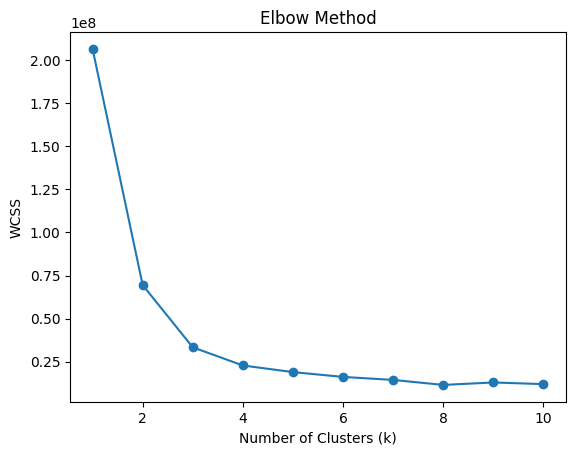

In [19]:
# Elbow method to determine optimal k


wcss = []
for k in range(1, 11):
    _, _, current_wcss = kmeans(base_class_array_cleaned, k)
    wcss.append(current_wcss)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


Using this graph, we determine that 3 is the optimal number of clusters, after which creating more cluster doesn't improve much the quality of the clustering

# Part 4 : Creation of the clusters

In [20]:
# We can now create our cluster using the kmeans function with parameter k = 3
cluster_labels, final_centroids, _ = kmeans(base_class_array_cleaned, k = 3)

print("Cluster Labels:", cluster_labels)
print("Final Centroids:", final_centroids)

Cluster Labels: [2 0 0 ... 1 0 0]
Final Centroids: [[1.52673289e-01 1.19729206e-01 1.34723306e-01 1.40210405e-01
  1.38559043e-01 1.32451668e-01 1.24629393e-01 1.01884477e-01
  1.66577548e-01 1.63962707e-01 1.57895967e-01 1.63237259e-01
  1.05906457e-01 9.82665196e-02 1.11545034e-01 8.98989066e-02
  8.50697756e-02 9.81237292e-02 7.68136010e-02 6.68075383e-02
  8.99349526e-02 9.19808298e-02 9.09786671e-02 8.98823589e-02
  6.77994192e-02 6.43219128e-02 6.02979548e-02 5.18510416e-02
  4.83376607e-02 5.42757139e-02 4.66710404e-02 3.90850008e-02
  9.17767620e+00 9.58638072e-01 2.15710290e-02 1.97909232e-02
  0.00000000e+00 0.00000000e+00 5.66912699e-04 0.00000000e+00
  9.58638072e-01 4.07950394e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30156350e-01
  5.29400110e-01 0.00000000e+00 4.04435508e-02 2.94862628e-01
  1.73129469e-01 5.32007873e-01]
 [1.19417422e-01 1.10999629e-01 1.27547309e-01 1.20947517e-01
  1.26307458e-01 1.24504372e-01 1.12375051e-01 9

We can represent the clusters in 2 dimension using PCA analysis

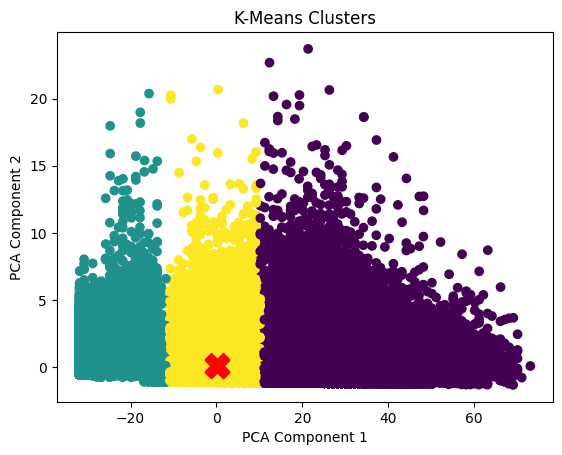

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
base_class_pca = pca.fit_transform(base_class_array_cleaned)


plt.scatter(base_class_pca[:, 0], base_class_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], s=300, c='red', marker='X')  # Centroids
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters')
plt.show()


To get a sense of what category of customer each cluster represents, we can look at the mean value of each variable for each cluster

In [21]:
# We keep the original column names
original_column_names = base_class_kmeans.columns.tolist()

# We create a new dataframe with the data and the cluster variable
clustered_data = pd.DataFrame(base_class_array_cleaned, columns=original_column_names)

clustered_data['Cluster'] = cluster_labels

# We can now group by cluster and compute the mean of each variable
print(clustered_data.groupby('Cluster').mean())

          ra_0122   ra_0222   ra_0322   ra_0422   ra_0522   ra_0622   ra_0722  \
Cluster                                                                         
0        0.152674  0.119729  0.134724  0.140211  0.138559  0.132452  0.124630   
1        0.119419  0.111002  0.127548  0.120949  0.126297  0.124499  0.112372   
2        0.218635  0.208667  0.228924  0.218119  0.217818  0.218177  0.206416   

          ra_0822   ra_0922   ra_1022   ra_1122   ra_1222   ra_0123   ra_0223  \
Cluster                                                                         
0        0.101884  0.166577  0.163962  0.157896  0.163238  0.105907  0.098267   
1        0.099974  0.118365  0.122812  0.121044  0.130273  0.095858  0.092591   
2        0.178797  0.210746  0.214706  0.217259  0.223545  0.165370  0.153802   

          ra_0323   ra_0423  ra_0523   ra_0623   ra_0723   ra_0823   ra_0923  \
Cluster                                                                        
0        0.111546  0.089899 

Finally, we can create 3 new dataframes, one for each cluster, to train 3 separate models on

In [ ]:
cluster_0 = pd.DataFrame(clustered_data[clustered_data['Cluster'] == 0])
cluster_1 = pd.DataFrame(clustered_data[clustered_data['Cluster'] == 1])
cluster_2 = pd.DataFrame(clustered_data[clustered_data['Cluster'] == 2])

In [ ]:
cluster_0.head()

,ra_01,ra_02,ra_03,ra_04,ra_05,ra_06,ra_07,ra_08,ra_09,ra_10,ra_11,ra_12,Age22,pp_mens_act,is_genre_Enfant,is_genre_Femme,is_genre_Homme,is_benef_Conjoint,is_benef_Enfant majeur,is_benef_Enfant mineur,is_benef_Salarie,is_foyer_ND,is_foyer_Salarie et 1 enfant,is_foyer_Salarie et 2 enfants,is_foyer_Salarie et 3+ enfants,is_foyer_Salarie et conjoint et 1 enfant,is_foyer_Salarie et conjoint et 2 enfants,is_foyer_Salarie et conjoint et 3+ enfants,is_foyer_Salarie et conjoint sans enfant,is_foyer_Salarie seul,region_ETR,region_IDF,region_OTH,Cluster
0,0.000000,0.59,0.000,0.0,0.0,0.00,0.000000,0.000,0.000000,0.0000,0.000000,0.0,45.0,0.049167,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
8,0.967500,0.00,0.000,0.0,0.0,1.34,0.665714,0.000,0.000000,0.6115,0.000000,0.0,72.0,0.298726,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
10,0.000000,0.00,1.185,0.0,0.0,0.00,0.000000,0.000,0.000000,0.0000,0.000000,0.0,55.0,0.098750,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
13,0.763333,0.00,0.000,0.0,0.0,0.71,0.000000,0.710,0.893333,0.0000,0.000000,0.0,54.0,0.256389,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
17,1.396667,0.00,0.000,0.0,0.0,0.00,0.000000,3.972,0.000000,3.6800,3.441667,0.0,62.0,1.040861,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
